# Mini-Project
## Using World Development Indicators
### Goal of this workbook is to explore life expectancy and GDP of countries to see if they are related
[Data](https://www.kaggle.com/worldbank/world-development-indicators/data)

In [95]:
import pandas as pd
import numpy as np
import folium
import random
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [2]:
#Let's take a look at the data
data = pd.read_csv('C:/Users/Josh/Desktop/Python for Data Science/Week 5 Visualization/Indicators.csv')
data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


In [3]:
#How many distinct countries, indicators, and years
print("The data has", data.shape[0], "rows and", data.shape[1], "columns.")
print("There are", len(set(data['CountryCode'])), "countries.")
print("There are", len(set(data['IndicatorCode'])), "indicators.")
print("There are", len(set(data['Year'])), "years.")

The data has 5656458 rows and 6 columns.
There are 247 countries.
There are 1344 indicators.
There are 56 years.


In [2]:
#Isolate indicator codes for life expectancy and GDP
gdp_cap = data['IndicatorCode'].str.contains('NY\.GDP\.PCAP\.KD$')
total_exp = data['IndicatorCode'].str.contains('SP\.DYN\.LE00\.IN$')

In [3]:
#Are the GDP and Life Expectancy data sets the same length?
gdp_stage = data[gdp_cap]
life_stage = data[total_exp]
#Let's check if there are any nulls
print(gdp_stage.isnull().any())
print(life_stage.isnull().any())

CountryName      False
CountryCode      False
IndicatorName    False
IndicatorCode    False
Year             False
Value            False
dtype: bool
CountryName      False
CountryCode      False
IndicatorName    False
IndicatorCode    False
Year             False
Value            False
dtype: bool


In [4]:
#Let's check how many years each data set contains
print("GDP Min Year =", gdp_stage['Year'].min(), "max:", gdp_stage['Year'].max())
print("Life Exp Min Year =", life_stage['Year'].min(), "max:", life_stage['Year'].max())

GDP Min Year = 1960 max: 2014
Life Exp Min Year = 1960 max: 2013


In [5]:
#Filter data to between 2000 and 2013
gdp_stage_trunc = gdp_stage[(gdp_stage['Year'] < 2014) & (gdp_stage['Year'] > 1999)]
print("GDP Min Year = ", gdp_stage_trunc['Year'].min(), "max: ", gdp_stage_trunc['Year'].max())
life_stage = life_stage[(life_stage['Year'] < 2014) & (life_stage['Year'] > 1999)]
print("Life Exp Min Year = ", life_stage['Year'].min(), "max: ", life_stage['Year'].max())

GDP Min Year =  2000 max:  2013
Life Exp Min Year =  2000 max:  2013


In [6]:
#Let's check the number of countries in each set
print(len(set(gdp_stage_trunc['CountryName'])))
print(len(set(life_stage['CountryName'])))
#Let's check all country differences between the two
print(np.setxor1d(gdp_stage_trunc['CountryName'],life_stage['CountryName']))

232
240
['Andorra' 'Curacao' 'French Polynesia' 'Guam' 'Korea, Dem. Rep.' 'Monaco'
 'Myanmar' 'New Caledonia' 'Sint Maarten (Dutch part)' 'Somalia'
 'South Sudan' 'St. Martin (French part)' 'Tuvalu' 'Virgin Islands (U.S.)']


In [7]:
#Looks like the distinct countries in the datasets are not the same
#Let's see which dataset has unique countries that the other does not contain
print("We have GDP information but not life expectancy for:", np.setdiff1d(gdp_stage_trunc['CountryName'],life_stage['CountryName']))
print("We have life expectancy information but not GDP for:", np.setdiff1d(life_stage['CountryName'],gdp_stage_trunc['CountryName']))

We have GDP information but not life expectancy for: ['Andorra' 'Monaco' 'Tuvalu']
We have life expectancy information but not GDP for: ['Curacao' 'French Polynesia' 'Guam' 'Korea, Dem. Rep.' 'Myanmar'
 'New Caledonia' 'Sint Maarten (Dutch part)' 'Somalia' 'South Sudan'
 'St. Martin (French part)' 'Virgin Islands (U.S.)']


In [9]:
#Let's remove countries that do not intersect
life_stage_trunc = life_stage[~life_stage.CountryName.isin(np.setdiff1d(life_stage['CountryName'],gdp_stage_trunc['CountryName']))]
gdp_stage_trunc = gdp_stage_trunc[~gdp_stage_trunc.CountryName.isin(np.setdiff1d(gdp_stage_trunc['CountryName'],life_stage['CountryName']))]
print(np.setxor1d(gdp_stage_trunc['CountryName'],life_stage_trunc['CountryName']))

[]


In [10]:
#Still not the same size, let's see if each country is represented the same number of times
newdf = gdp_stage_trunc.groupby(['CountryName'])['CountryCode'].count() - life_stage_trunc.groupby(['CountryName'])['CountryCode'].count()
newdf.iloc[newdf.nonzero()]

CountryName
Afghanistan             -2
Angola                 -13
Aruba                   -4
Channel Islands         -6
Dominica                13
Eritrea                 -2
Faeroe Islands         -13
Greenland               -2
Isle of Man              7
Liechtenstein           -4
Maldives                -1
Marshall Islands        13
Palau                   12
San Marino              -3
Seychelles               2
St. Kitts and Nevis     13
Syrian Arab Republic    -6
Name: CountryCode, dtype: int64

In [11]:
#Looks like some countries have data for years that the others do not, let's remove them from both dataframes
countriesrm = ['Afghanistan','Angola','Aruba','Channel Islands','Dominica','Eritrea','Faeroe Islands','Greenland','Isle of Man',
             'Liechtenstein', 'Maldives','Marshall Islands','Palau','San Marino','Seychelles','St. Kitts and Nevis','Syrian Arab Republic']
life_stage_trunc = life_stage_trunc[~life_stage_trunc.CountryName.isin(countriesrm)]
gdp_stage_trunc = gdp_stage_trunc[~gdp_stage_trunc.CountryName.isin(countriesrm)]

In [90]:
df_merge = pd.merge(gdp_stage_trunc, life_stage_trunc,how = 'left', left_on = ['CountryName','Year'],right_on = ['CountryName','Year'])
df_merge.rename(columns={'Value_x':'GDPPC', 'Value_y':'Life Expectancy'}, inplace=True)
df_merge.groupby(['CountryName'])['GDPPC', 'Life Expectancy'].mean()

,GDPPC,Life Expectancy
CountryName,,
Albania,2977.186848,76.202930
Algeria,3041.937716,72.585561
Antigua and Barbuda,11980.660788,74.658287
Arab World,3913.801044,69.225104
Argentina,6163.911856,74.907564
Armenia,1722.939692,73.360082
Australia,34515.243824,80.963066
Austria,39020.179358,79.767073
Azerbaijan,2141.443089,69.191911


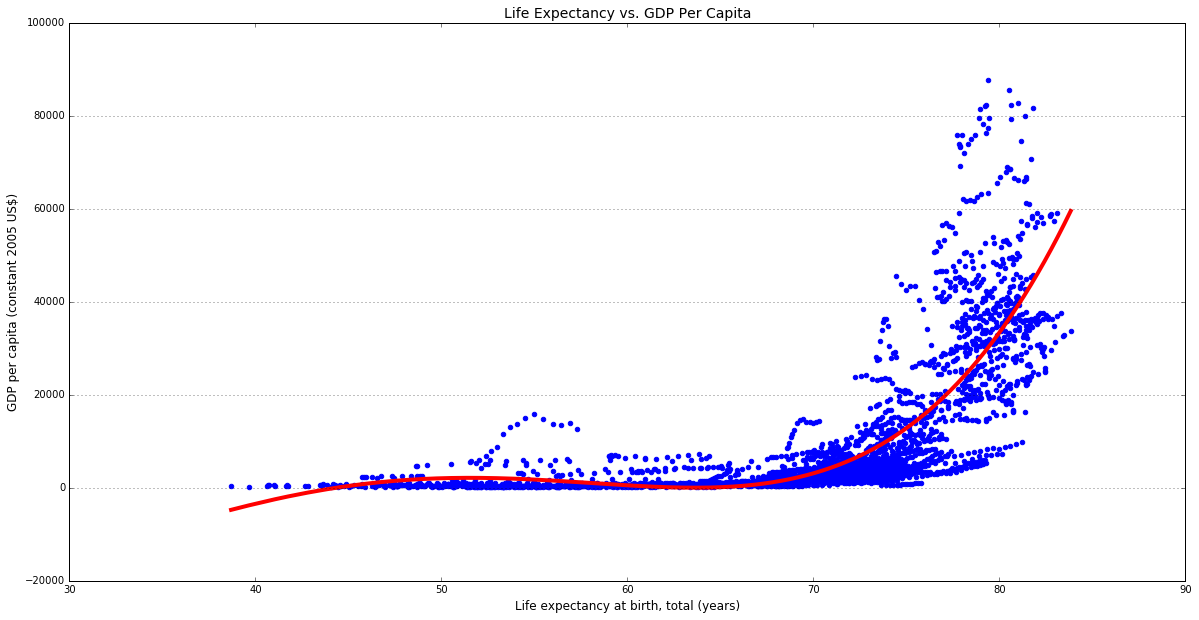

In [133]:
%matplotlib inline
fig, axis = plt.subplots(figsize = (20,10))

axis.yaxis.grid(True)
axis.set_title('Life Expectancy vs. GDP Per Capita',fontsize=14)
axis.set_ylabel(gdp_stage_trunc['IndicatorName'].iloc[0],fontsize=12)
axis.set_xlabel(life_stage['IndicatorName'].iloc[0],fontsize=12)

Y = gdp_stage_trunc['Value']
X = life_stage_trunc['Value']

plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 4))(np.unique(X)), '-r', linewidth = 4)

axis.scatter(X, Y, color = 'b')
plt.show()

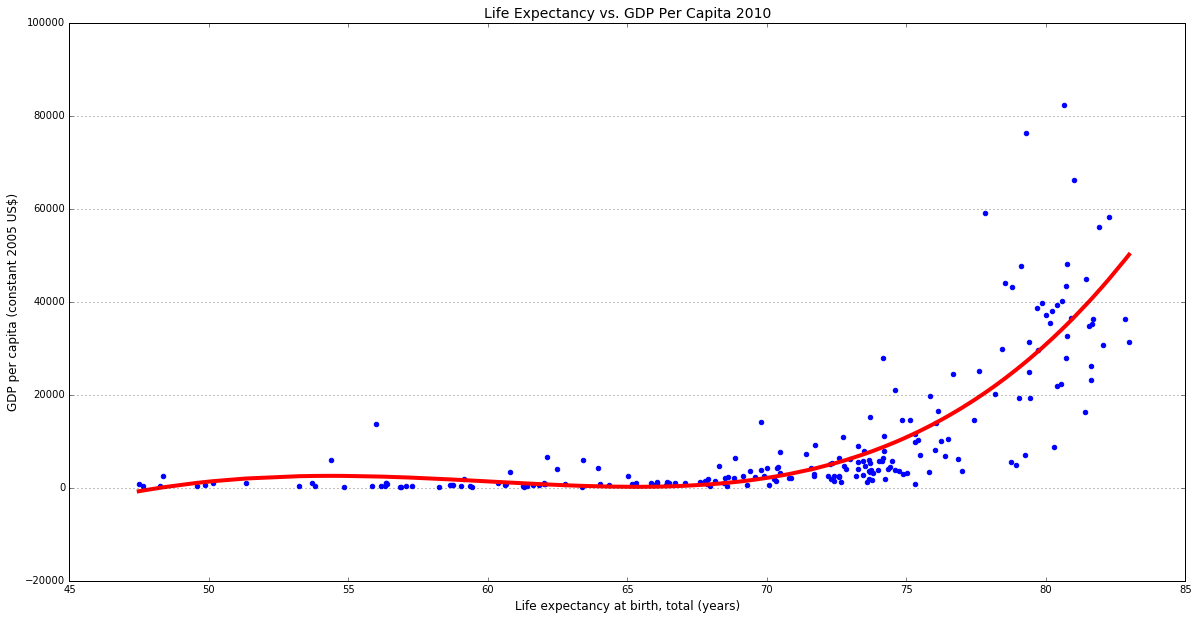

In [146]:
#We can also select by year 
%matplotlib inline
choose_year = 2010
fig, axis = plt.subplots(figsize = (20,10))
axis.yaxis.grid(True)
axis.set_title('Life Expectancy vs. GDP Per Capita' + ' ' + str(choose_year),fontsize=14)
axis.set_ylabel(gdp_stage_trunc['IndicatorName'].iloc[0],fontsize=12)
axis.set_xlabel(life_stage['IndicatorName'].iloc[0],fontsize=12)

Y = gdp_stage_trunc.loc[gdp_stage_trunc['Year'] == choose_year, 'Value']
X = life_stage_trunc.loc[life_stage_trunc['Year'] == choose_year, 'Value']

plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 4))(np.unique(X)), '-r', linewidth = 4)

axis.scatter(X, Y, color = 'b')
plt.show()

In [16]:
countries = 'C:/Users/Josh/Desktop/Python for Data Science/Week 5 Visualization/world-countries.txt'
plot_data = life_stage[['CountryCode','Value']]

In [17]:
map = folium.Map(location=[10, 0], zoom_start=1.5)

In [18]:
map.choropleth(geo_data=countries, data=plot_data,
             columns=['CountryCode', 'Value'],
             key_on='feature.id',
             fill_color='YlGnBu', 
             fill_opacity=0.7, 
             line_opacity=0.2,
             legend_name = life_stage.iloc[0]['IndicatorName'])

In [19]:
map.save('plot_data.html')

In [20]:
from IPython.display import HTML
HTML('<iframe src=plot_data.html width=900 height=450></iframe>')

In [142]:
gdp_stage_trunc.loc[gdp_stage_trunc['Year'] == 2010, 'Value']

4839188     4285.818965
4839728     7309.906447
4840312     9763.560846
4840962     5669.091316
4841634     2511.589009
4842430    32647.954456
4843061    19821.478639
4843803     4209.195778
4844652    29681.322027
4845295      891.256808
4845843      506.264927
4846454    29820.955755
4847125    10956.899347
4847775    35533.799840
4848437     5715.518819
4849136     5307.569267
4849953      528.396144
4850620     2145.340021
4851475      367.816474
4852338     1076.157603
4853160     5013.688363
4853829     2612.723003
4854713     2343.965646
4855519    43225.117024
4856108    31292.299401
4856752     3412.642520
4857267     2533.971819
4857750     4285.076405
4858410      934.803067
4859268      988.049577
               ...     
5000154     5388.278418
5001001      812.037290
5001807     4262.950097
5002473     2440.636937
5003353    44877.910497
5004170    58138.631206
5005756      419.620869
5006738      512.990167
5007775     3410.427649
5008716      682.596437
5009504      387